In [1]:
x=1

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import muon as mu
import scib

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [3]:
rna = sc.read('../../../data/10xpbmc10k-2020/expressions_hvg.h5ad')
rna = rna.copy()
rna

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/cell_type' was written without encoding metadata.
  categories = read_elem(categories_dset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/cell_type' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return read_ele

AnnData object with n_obs × n_vars = 10000 × 4000
    obs: 'cell_type'
    layers: 'count'

In [4]:
atac = sc.read('../../../data/10xpbmc10k-2020/peaks.h5ad')
atac = atac.copy()
atac

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/cell_type' was written without encoding metadata.
  categories = read_elem(categories_dset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/cell_type' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/muon/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/_index' was written without encoding metadata.
  return read_ele

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type'
    layers: 'binary', 'cpm_norm', 'tf-idf'

In [5]:
mdata = mu.MuData({'rna': rna, 'atac': atac})
mdata

MuData object with n_obs × n_vars = 10000 × 44086
  2 modalities
    rna:	10000 x 4000
      obs:	'cell_type'
      layers:	'count'
    atac:	10000 x 40086
      obs:	'cell_type'
      layers:	'binary', 'cpm_norm', 'tf-idf'

In [7]:
mdata.obs['cell_type'] = mdata['rna'].obs['cell_type'].astype('category').copy()

In [8]:
np.max(rna.X)

7.1491437

In [10]:
atac.X = atac.layers['cpm_norm'].copy()
np.max(atac.X)

2.6131697

In [11]:
mu.tl.mofa(
    mdata, 
    gpu_mode = True,
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=10000 samples and D=4000 features...
Loaded view='atac' group='group1' with N=10000 samples and D=40086 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights

In [12]:
sc.pp.neighbors(mdata, use_rep='X_mofa')
sc.tl.umap(mdata)

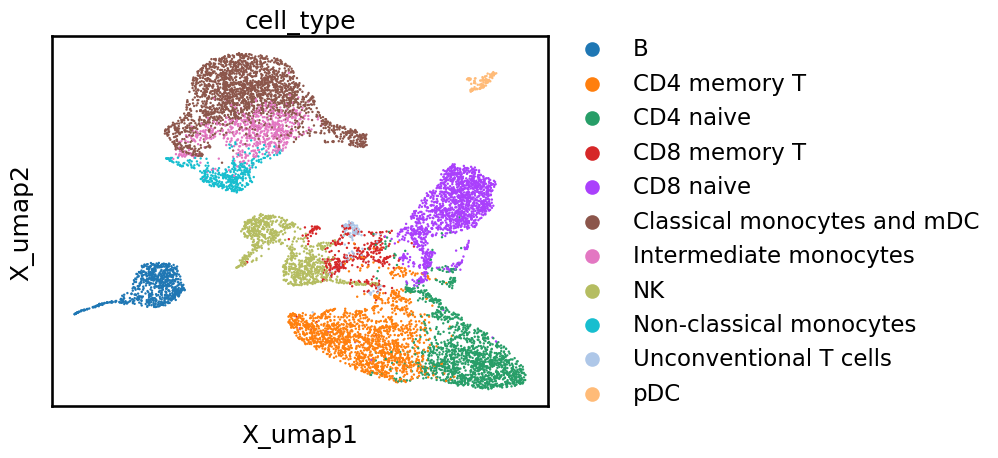

In [13]:
mu.pl.embedding(mdata, color=['cell_type'], ncols=1, basis='umap', save='_10x_mofa.png')

In [14]:
scib_anndata = sc.AnnData(mdata.obsm['X_mofa']).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.uns['neighbors'] = mdata.uns['neighbors'].copy()
scib_anndata.obsp['connectivities'] = mdata.obsp['connectivities'].copy()
scib_anndata.obsp['distances'] = mdata.obsp['distances'].copy()
scib_anndata.obsm['X_mofa'] = mdata.obsm['X_mofa'].copy()

In [15]:
scib_anndata.write('10x_mofa.h5ad')

In [18]:
# need to trick scIB a bit to calculate ASW cell type but not ASW batch, 
# so set batch_key to be sth random, will ignore later
scib_anndata.obs['batch'] = '0'
scib_anndata.obs['batch'][:3000] = '1'

In [19]:
metrics_mofa = scib.metrics.metrics(
    scib_anndata, 
    scib_anndata, 
    batch_key='batch', 
    label_key='cell_type', 
    embed='X_mofa',
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_mofa

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.791609
ARI_cluster/label,0.718718
ASW_label,0.632117
ASW_label/batch,0.953821
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.578131
graph_conn,0.992759
kBET,NaN


In [20]:
metrics_mofa.to_csv('10x_mofa.csv')